# Simple neuroevolution

Neuroevolution is a technique to train Deep Learning models. It can acheive results competitive with models trained using gradient-descent based DL algorithms. 

This article will focus on optimizing a simple linear function, with 1 weight and 1 bias (a total of 2 parameters). The algorithm will train on a simple Celsius to Fahrenheit dataset

In [25]:
import numpy as np

Our goal is to optimize the following function through an evolutionary method

$$
y = w_1x + w_2
$$

Find $w_1$ and $w_2$

## Neural Network

We start by implementing a `Linear` layer class. All this layer does is replicate a linear function. Note there is no `backward` function, for we have no need of derivatives in genetic evolution

In [3]:
class Linear():
    def __init__(self, n_in, n_out):
        limit = 1 / np.sqrt(n_in)
        self.W = np.random.uniform(-limit, limit, (n_in, n_out))
        self.b = np.random.rand(1, n_out)  # Biases

    def forward(self, x):
        return np.dot(x, self.W) + self.b
    
    def apply_weights(self, w):
        # This method is not optimized for more than 1 input. 
        self.W = np.array(w[0]).reshape(-1, 1)
        self.b = np.array(w[1]).reshape(-1, 1)
        
    def __call__(self, x):
        return self.forward(x)

## Data

Initialize the data and reshape it so that it can fit into the neural network. `x_train` is celsius values and `y_train` is fahrenheit values.

In [4]:
x_train = np.array([-40, -10, 0, 8, 15, 22, 38], dtype=np.float32)  # Celsius
y_train = np.array([-40, 14, 32, 46, 59, 72, 100], dtype=np.float32)  # Fahrenheit
x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

## Model

In this section, the model is initialized with 1 input and 1 output. The loss function is defined. Note that the loss function is just mean_squared error, which is a good loss function for regression tasks

In [6]:
model = Linear(1, 1)

In [7]:
sample_weights = np.array([9/5, 32]) # Our final weights should be very close to this.

> Note how we take the reciprocal of MSE here. This is because our evolutionary algorithm maximizes the loss function rather than minimizing it. One could configure the algorithm to minimize the loss function, if they wanted.

In [8]:
def loss(y_true, y_pred):
    return 1/np.mean(np.power(y_true - y_pred, 2));

In [26]:
loss(model(x_train), y_train)

15.808014533475669

## Evolutionary Algorithm

Now we come to the good parts.

The first function is the fitness function. This determines how fit each set of paramters is, by using the loss function to calculate the score of a certain set of paramters

In [10]:
def fitness_func(solution):
    model.apply_weights(solution)
    return loss(model(x_train), y_train)

The second function calculates the fitness of an entire population of paramters. The results of this will be used to select the mating pool

In [11]:
def calc_population_fitness(pop):
    fitness = np.zeros(pop.shape[0])
    for i, params in enumerate(pop):
        fitness[i] = fitness_func(params)
    return fitness

Selecting the best "parents" is very simple. All this function does is take the top 5 paramters with the highest fitness scores. These parents will constitute the mating pool

In [12]:
def select_best_parents(pop, num_parents, fitness):
    parents = np.zeros((num_parents, pop.shape[1]))
    topk_fitness =  np.argsort(fitness)[-num_parents:]
    for parent_n in range(num_parents):
        solution = pop[topk_fitness[parent_n]]
        parents[parent_n] = solution
    return parents

This function is the "mating" function. Basically, this function takes 2 parents from the mating pool and combines their genes to create an offspring.

Say you have 2 parents `parent_1` and `parent_2`. The offspring will be a combination of these parents. In other words, the offspring will be `offspring = [parent_1[0], parent_2[1]]`. The offspring takes the first parameter of `parent_1` and the second parameter of `parent_2`.

In [13]:
def mate(parents, offspring_size):
    offspring = np.zeros(offspring_size)
    crossover_point = np.uint8(offspring_size[1]/2)
    for k in range(offspring_size[0]):
        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

In this program, we have 95 offspring, as will be seen later. Many of these offspring are going to be the same, and if we keep iterating through generations, the offspring will always have the same numbers. So, we create a mutation function that mutates the offspring slightly. After all, mutation is one of the driving factors of evolution. Mutating the offspring each generation will ensure that the "species" evolves with each generation.

Some offspring will have good mutations and others will have bad mutations. Our algorithm weeds out the offspring with bad mutations and keeps the one with good mutations (i.e higher fitness scoes).

In [17]:
def mutate(offspring):
    for k in range(offspring.shape[0]):
        rand_number = np.random.uniform(-1.0, 1.0, 1)
        rand_param = np.random.randint(0, offspring.shape[1], size=1)
        offspring[k, rand_param] += rand_number

Initialize the initial population of 100 sets of parameters, or 100 neural networks

In [18]:
initial_population = np.random.randint(-10, 10, size=[100, 2])

We will evolve our paremeters for 100 generations and our mating pool will consist of 5 parents

In [19]:
num_generations = 100
NUM_PARENTS=5

Now, we set all the functions into action. This is the "evolution".

1. Start by calculating the fitness of the population
2. Pick the mating pool from that population
3. Mate those parents to generate the offspring
4. Mutate the offspring.
5. Combine the parents and offspring to create a new population. *In this case, our population is 5 parents and 95 offspring each generation, so we will always have a population of 100*
6. Move to the next generation with the population as the new population created in the previous step

In [20]:
population = initial_population
for generation in range(num_generations + 1):
    fitness = calc_population_fitness(population)
    best_parents = select_best_parents(population, NUM_PARENTS, fitness)
    offspring = mate(best_parents, (initial_population.shape[0] - best_parents.shape[0], initial_population.shape[1]))
    mutate(offspring)
    population = np.zeros(initial_population.shape)
    population[0:best_parents.shape[0]] = best_parents
    population[best_parents.shape[0]:] = offspring
    if generation % 10 == 0:
        print(f"Generation: {generation}, Best Solution: {best_parents[0]}, Loss: {fitness_func(best_parents[0])}")

Generation: 0, Best Solution: [3. 8.], Loss: 0.0009002057613168725
Generation: 10, Best Solution: [ 2.         16.75235077], Loss: 0.004444533166596266
Generation: 20, Best Solution: [ 1.87469608 24.92770189], Loss: 0.020997877055740882
Generation: 30, Best Solution: [ 1.8018842  31.86814524], Loss: 13.210000216192187
Generation: 40, Best Solution: [ 1.8018842  31.92457969], Loss: 13.994822568506123
Generation: 50, Best Solution: [ 1.8018842  31.93072679], Loss: 14.010060002933049
Generation: 60, Best Solution: [ 1.79972363 31.93235495], Loss: 15.41369088084888
Generation: 70, Best Solution: [ 1.79856772 31.94339828], Loss: 15.800243319191257
Generation: 80, Best Solution: [ 1.79856772 31.95238306], Loss: 15.807957064621492
Generation: 90, Best Solution: [ 1.79856772 31.95234129], Loss: 15.808014533475669


Remember earlier I mentioned that our final weights should be close to [9/5, 32]. Note that the solution at the end of generation 100 is very close to our desired weights. That means that genetic evolution successfully optimized our simple neural network.

Now, we select the best set of weights from each population. If we wanted, we could save the best weights from each generation and select the weights from there. But in this case, we select the best weights from the last generation, because the last generation has the best weights

In [27]:
best_solution = select_best_parents(population, 1, fitness)[0]
model.apply_weights(best_solution) # Set the model weights as the best solution.

## Plot the results

Compare the predicted values with the real values

In [28]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Predicted vs Real')

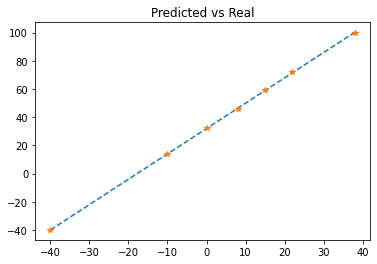

In [30]:
plt.plot(x_train, model(x_train), '--') # Dashed line is the prediction line
plt.plot(x_train, y_train, '*') # The stars is our actual data.
plt.title("Predicted vs Real")

Notice how the lines are basically overlaid on each other. This means that our parameters are highly accurate. 

Thank you for reading this tutorial. Check out my other tutorials.